In [1]:
import os
import tarfile
import urllib

In [2]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
        tgz_path = os.path.join(housing_path, "housing.tgz")
        urllib.request.urlretrieve(housing_url, tgz_path)
        housing_tgz = tarfile.open(tgz_path)
        housing_tgz.extractall(path=housing_path)
        housing_tgz.close()

In [3]:
HOUSING_PATH = os.path.join("datasets", "housing")

In [4]:
import os
import tarfile
import urllib
HOUSING_PATH = os.path.join("datasets", "housing")
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


<AxesSubplot:>

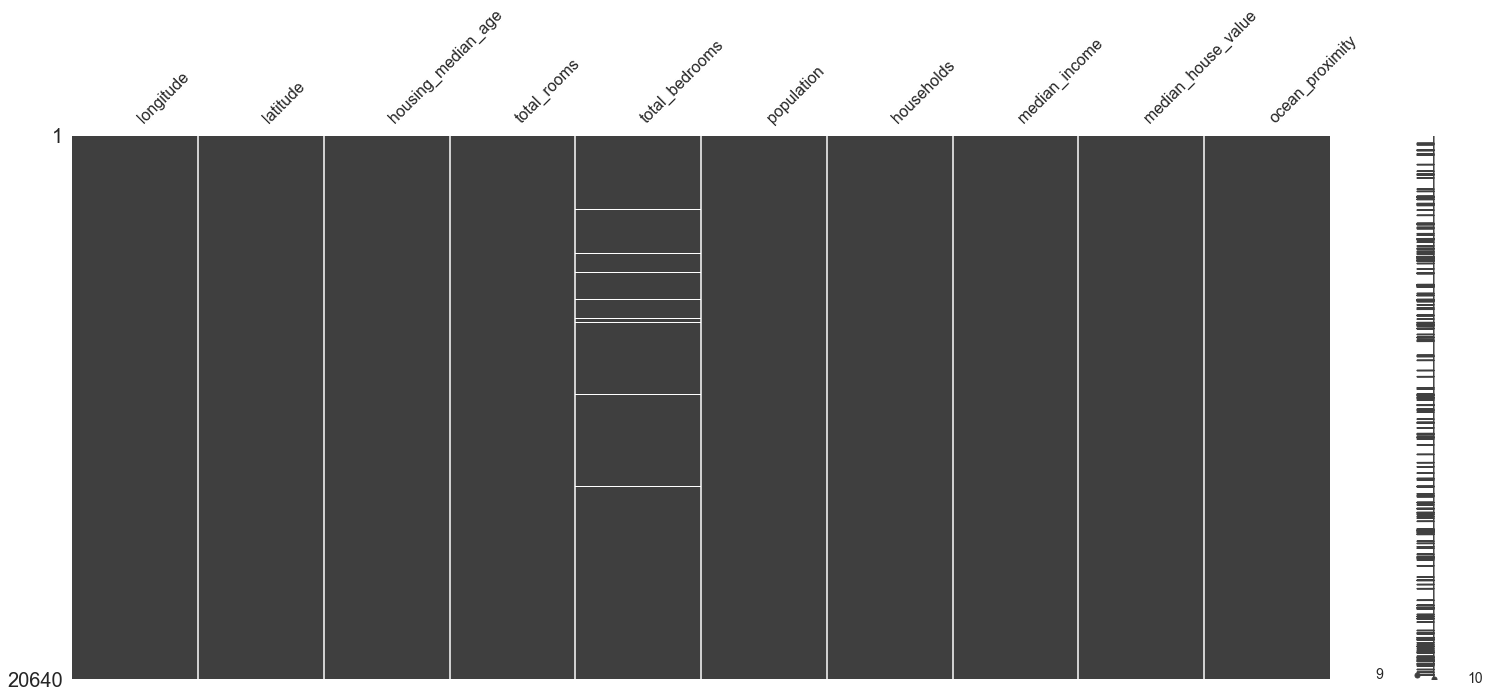

In [5]:
msno.matrix(housing)

In [6]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

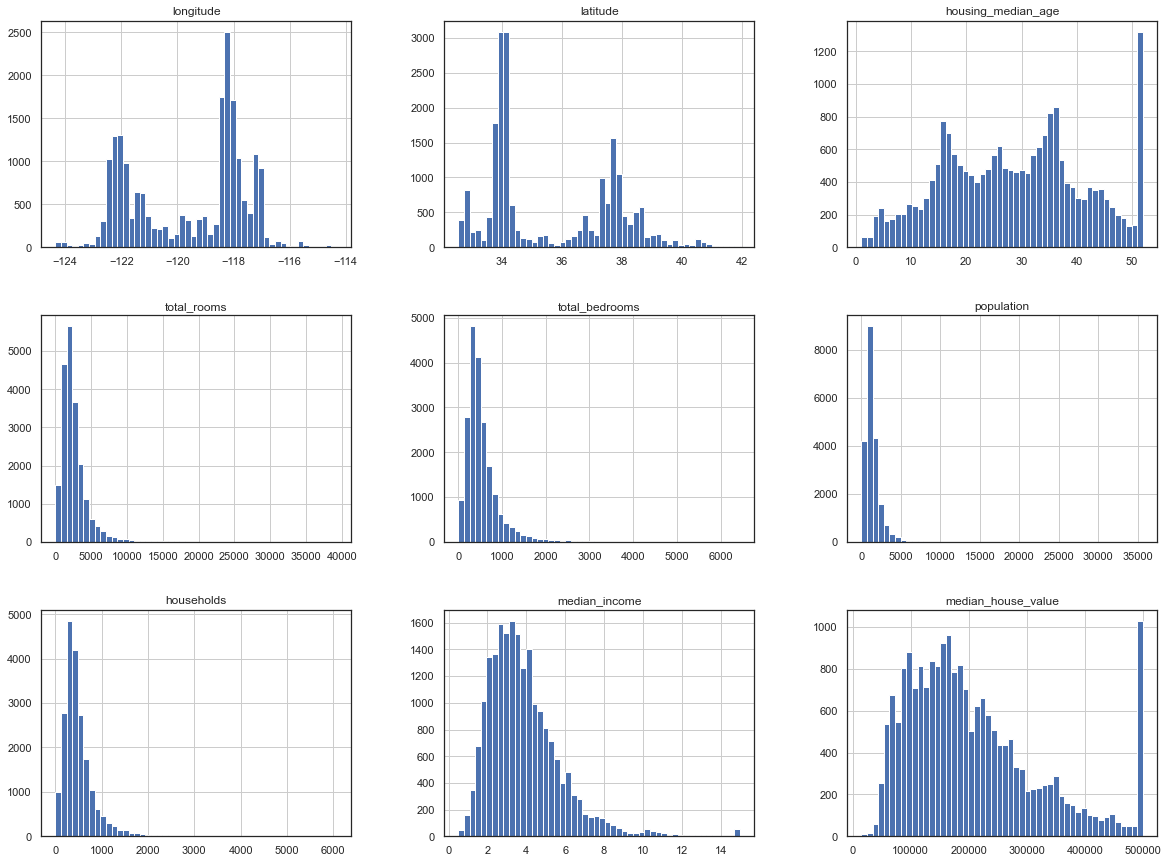

In [7]:
housing.hist(bins=50,figsize=(20,15))
plt.show()

<AxesSubplot:>

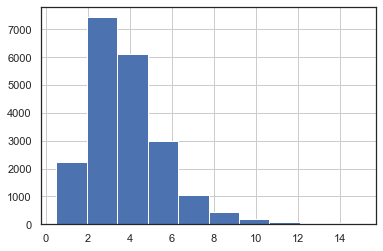

In [8]:
housing["median_income"].hist()

<h3>train data /test data 나누기</h3>

In [9]:
#실행 할 때마다 지속적으로 바뀐다
def split_train_test(data,test_radio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data)*test_radio)
    test_indices = shuffled_indices[:text_set_size]
    train_indices = shuffled_indices[test_set_size]
    return data.iloc(train_indices), data.iloc[test_indices]

In [10]:
from zlib import crc32 # 헤시값을 기준으로 전체 데이터보다 20% 낮으면  테스트 세트
def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio*2**32

In [11]:
def split_train_test_by_id(data, test_ratio,id_column):
    ids =data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_,test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [12]:
housing_with_id = housing.reset_index() 
train_set, test_set = split_train_test_by_id(housing_with_id,0.2,"index") #20%로 테스트 셋 트레인 셋 나눔

In [13]:
#고유 식별자가 없는 경우 데이터가 업데이트가 되면 지속적으로 사용이 불가능해 고유 식별자를 대체할 수 있는 위도 경도를 합하여 인댁스화 한다
housing_with_id["id"] = housing["longitude"]*1000+housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id,0.2,"index")
housing_with_id["id"] 

0       -122192.12
1       -122182.14
2       -122202.15
3       -122212.15
4       -122212.15
           ...    
20635   -121050.52
20636   -121170.51
20637   -121180.57
20638   -121280.57
20639   -121200.63
Name: id, Length: 20640, dtype: float64

In [14]:
#사이킷 런을 사용한 데이터 분리 train_test_split, split_train_test와 비슷하나 두가지 특징 존제
#1. random_state 매개변수, 2. 행의 개수가 같은 여러개의 데이터셋을 넘겨서 같은 인덱스 기반으로 나눌 수 있다
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [15]:
#계층적 셈플링 stratified sampling
#train, test set을 뽑을 때 대표성을 위해서 데이터의 특징을 반드시 반영 예) 전 인구가 남자 6 : 여자 4 라면 test set 도 반드시 6:4를 따라야 한다 이를 이라고 한다
#계층별로 충분한 데이터가 있어야 한다 

In [16]:
#housing data 중위소득 계층화
housing["income_cat"] = pd.cut(housing["median_income"],
                                                      bins= [0.,1.5,3.0,4.5,6., np.inf],
                                                      labels=[1,2,3,4,5])

<AxesSubplot:>

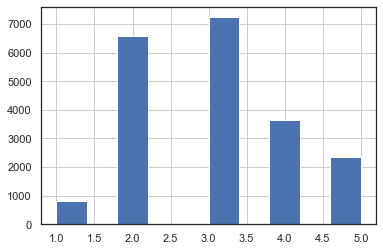

In [17]:
housing["income_cat"].hist()

In [18]:
#계층적 셈플링
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing,housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [19]:
strat_test_set["income_cat"].value_counts()

3    1447
2    1316
4     728
5     473
1     164
Name: income_cat, dtype: int64

In [20]:
#income_cat 지우기
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

<h3>데이터 이해를 위한 탐색과 시각화</h3>

In [21]:
housing = strat_train_set.copy()

1. 지리적 데이터 시각화

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

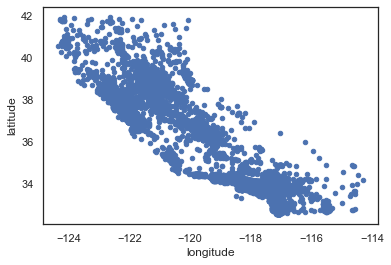

In [22]:
housing.plot(kind="scatter", x="longitude",y="latitude")

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

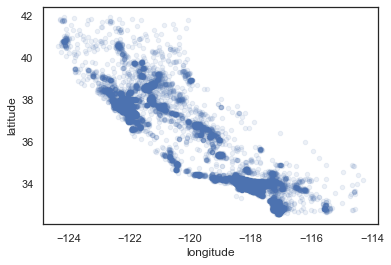

In [23]:
#alpha = 0.1, 밀집된 데이터를 잘 보여줌
housing.plot(kind="scatter", x="longitude",y="latitude",alpha = 0.1)

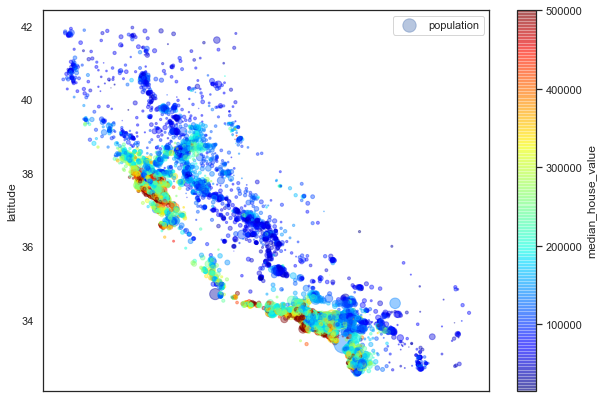

In [24]:
#더 두드러진 패턴을 보려면 매개변수 조절 - 가격 반영, 인구수
# s = 인구 매개변수(반지름) , c = 가격 매개변수(색상), jet이라는 color map 사용
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
                s=housing["population"]/100, label="population",figsize=(10,7),
                c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)
plt.legend()

In [25]:
# import matplotlib.image as mpimg
# california_img = mpimg.imread('data/california.jpeg', format='jpeg')
# ax = housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
#                 s=housing["population"]/100, label="population",figsize=(10,7),
#                  cmap=plt.get_cmap("jet"), colorbar=True,c="median_house_value")

# plt.imshow(california_img, extent=[-124.55, -113.80, 32.45,42.05], alpha=0.5,cmap=plt.get_cmap('jet'));

# plt.ylabel('latityde',fontsize=14)
# plt.xlabel('longtitude',fontsize=14)

# prices = housing['median_house_value']
# tick_values= np.linspace(prices.min(), prices.max(), 11)

# # cbar.ax.set_yticklabels(["$"+str((round(v/1000))) for v in tick_values],fontsize=14)
# # cbar.set_label('median house value', fontsize=16)

# plt.legend(fontsize=16); plt.show()

2. 표준 상관계수 standard correlation coefficient(피어슨 상관계수) corr()

In [26]:
corr_matrix=housing.corr()

In [27]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

array([[<AxesSubplot:xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_house_value'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_income'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_income'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='median_income', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='total_rooms'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='housing_median_age'>,
        <AxesSubplot:xlabel='median_incom

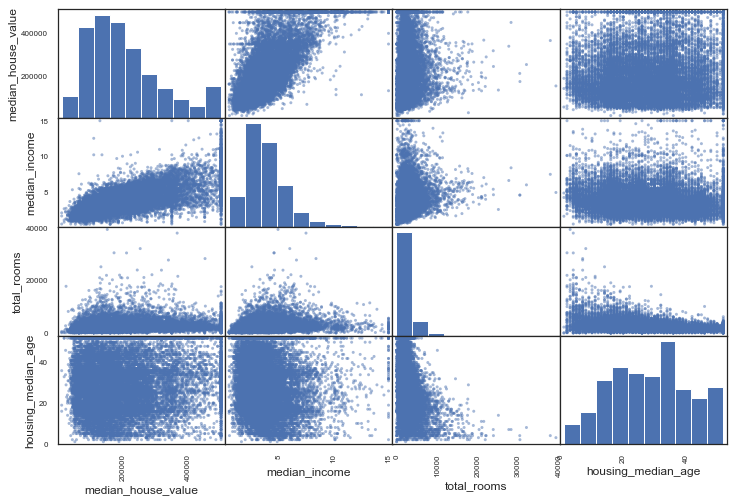

In [28]:
#특성 사이의 상관관계를 확인하는 다른 방법은 숫자형 특성 사이에 산점도를 그려주는 scatter_matrix함수 사용
#중간 주택 가격과 상관관계가 높아 보이는 특성 몇개만
from pandas.plotting import scatter_matrix
attributes = ["median_house_value" , "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12,8))

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

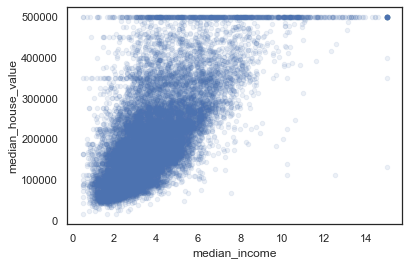

In [29]:
#median income과 value의 상관관계 알아보기
housing.plot(kind="scatter",x="median_income",y="median_house_value",alpha=0.1)

In [30]:
# 왼쪽 아래에서 위로 향하는 선형 모양을 방해하는 value 500000 , 450000의 가로선을 구역을 제거하는 것이 좋다

3. 특성조합

In [31]:
housing["room_per_household"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_household"] = housing["population"] / housing["households"]

In [32]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
room_per_household          0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

In [33]:
#bedrooms_per_room 이 다른 기존 데이터보다 높은 상관관계를 보임

4. 알고리즘을 위한 데이터 준비(자동화)
-어떤 데이터셋에 대해서도 데이터 변환을 손쉽게 반복 
-향후 프로젝트에 사용할 수 있는 변환 라이브러리를 점진적으로 구축
-실제 시스템에서 알고리즘에 새 데이터 주입하기 전 변환시키는 데 함수를 사용
-여러 가지 데이터 변환을 쉽게 시도할 수 있고 어떤 조합이 가장 좋은지 확인 편리

In [34]:
# 훈련 데이터의 종속 변수, 독립 변수를 나누어줌
housing = strat_train_set.drop("median_house_value",axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [35]:
housing_labels

17606    286600.0
18632    340600.0
14650    196900.0
3230      46300.0
3555     254500.0
           ...   
6563     240200.0
12053    113000.0
13908     97800.0
11159    225900.0
15775    500001.0
Name: median_house_value, Length: 16512, dtype: float64

In [36]:
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,<1H OCEAN
...,...,...,...,...,...,...,...,...,...
6563,-118.13,34.20,46.0,1271.0,236.0,573.0,210.0,4.9312,INLAND
12053,-117.56,33.88,40.0,1196.0,294.0,1052.0,258.0,2.0682,INLAND
13908,-116.40,34.09,9.0,4855.0,872.0,2098.0,765.0,3.2723,INLAND
11159,-118.01,33.82,31.0,1960.0,380.0,1356.0,356.0,4.0625,<1H OCEAN


5. 데이터 정제

In [37]:
#total_bedrooms none 값을 채우기 

In [38]:
median = housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median, inplace=True)

In [39]:
#SimpleImputer none 값을 쉽게 다루게 함
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

In [40]:
#object type 데이터 제거
housing_num = housing.drop("ocean_proximity",axis=1)

In [41]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [42]:
# imputer는 각 특성의 중간값을 statistics_ 속성에 저장 
# 추가적인 데이터를 대입할 때 어떤 값이 누락될지 확신 할 수 없으므로 imputer를 적용
imputer.statistics_ , housing_num.median().values


(array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
         408.    ,    3.5409]),
 array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
         408.    ,    3.5409]))

In [43]:
# imputer 객체를 이용해 훈련 세트에 누락된 값을 학습한 중간 값으로 바꿀 수 있다
#일관성 : imputer 추정기, transform 변환기, fit_transform() 예측기 

In [44]:
X = imputer.transform(housing_num)

In [45]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)
housing_tr

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347
...,...,...,...,...,...,...,...,...
6563,-118.13,34.20,46.0,1271.0,236.0,573.0,210.0,4.9312
12053,-117.56,33.88,40.0,1196.0,294.0,1052.0,258.0,2.0682
13908,-116.40,34.09,9.0,4855.0,872.0,2098.0,765.0,3.2723
11159,-118.01,33.82,31.0,1960.0,380.0,1356.0,356.0,4.0625


6. 텍스트와 범주형

In [46]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


In [47]:
#OrdinalEncoder 텍스트 데이터를 수치화 시킴
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [48]:
#catregories_ 인스턴스 변수를 사용 카테고리 목록을 얻을 수 있음
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [49]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [50]:
#데이터의 열이 많아지는 경우
housing_cat_1hot.toarray(),ordinal_encoder.categories_

(array([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        ...,
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.]]),
 [array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
        dtype=object)])

*** 나만의 변환기 ***
fit() -> return self
transform(),fit_transform() 메소드 구현

In [51]:
from sklearn.base import BaseEstimator, TransformerMixin
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self 
    def transform(self,X):
        rooms_per_household = X[: , rooms_ix] / X[:,households_ix]
        population_per_household = X[: , bedrooms_ix] / X[:, rooms_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

7. 특성 스케일링 
MinMaxScaler = 0~1 사이의 번위에 들도록 스케일링 (정규화)
StandardScaler = 평균을 빼고 표준편차로 나누어 경과 분포의 분산이 1 (표준화)

In [52]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder',  CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])


full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(),cat_attribs),
])
housing_prepared = full_pipeline.fit_transform(housing)

In [53]:
#데이터 전체 변환 

housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

8. 훈련세트에서 훈련 후 평가

In [54]:
from sklearn.metrics import mean_squared_error

In [55]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [56]:
housing_labels

17606    286600.0
18632    340600.0
14650    196900.0
3230      46300.0
3555     254500.0
           ...   
6563     240200.0
12053    113000.0
13908     97800.0
11159    225900.0
15775    500001.0
Name: median_house_value, Length: 16512, dtype: float64

In [57]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared =full_pipeline.transform(some_data)
print("예측", lin_reg.predict(some_data_prepared))

예측 [210528.01750105 317824.00920324 210815.82440675  59307.5245779
 189946.78983305]


In [58]:
print("레이블",list(some_labels))

레이블 [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [59]:
#DecisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)

In [60]:
#k-fold 교차검증
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                                        scoring="neg_mean_squared_error",cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [61]:
def  display_scores(scores):
    print("점수",scores)
    print("평균",scores.mean())
    print("표준편차",scores.std())
display_scores(tree_rmse_scores)

점수 [70215.16036582 66245.80538078 73473.68148627 70247.77988638
 70788.76342204 71954.01833965 71399.33532915 69773.44904271
 69785.31022529 68485.89591729]
평균 70236.91993953733
표준편차 1857.2889264901717


In [62]:
#선형회기
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [63]:
#rmse 추정 값 또는 모델이 예측한 값과 실제 환경에서 관찰되는 값의 차이
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68635.59352516982

In [64]:
scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                                        scoring="neg_mean_squared_error",cv=10)
lin_rmse_scores = np.sqrt(-scores)
display_scores(tree_rmse_scores)

점수 [70215.16036582 66245.80538078 73473.68148627 70247.77988638
 70788.76342204 71954.01833965 71399.33532915 69773.44904271
 69785.31022529 68485.89591729]
평균 70236.91993953733
표준편차 1857.2889264901717


In [65]:
#랜포
from sklearn.ensemble import RandomForestRegressor 
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse


scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                        scoring="neg_mean_squared_error",cv=10)
forest_rmse_scores = np.sqrt(-scores)
display_scores(forest_rmse_scores)

점수 [48200.92224094 46369.01971444 49418.88582755 50740.28896578
 49290.76371841 52577.8266155  48454.43813562 51250.62564134
 50923.86729321 49566.98164214]
평균 49679.36197949453
표준편차 1685.8351181953099


In [66]:
#모델 저장하기

# import joblib 
# joblib.dump(my_model, "my_model.pkl")
# my_model_loaded = joblib.load("my_model.pkl")

In [67]:
#모델 세부 튜닝
from sklearn.model_selection import GridSearchCV
 
param_grid = [
        {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
        {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
    ]
forest_reg = RandomForestRegressor()
 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
 
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [68]:
#최적의 값 추정하기
from sklearn.model_selection import GridSearchCV
 
param_grid = [
        {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
        {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
    ]
forest_reg = RandomForestRegressor()
 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
 
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [69]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [70]:
# 최적의 추정기 적용
grid_search.best_estimator_
RandomForestRegressor(bootstrap=True, criterion="mse", max_depth=None,
                     max_features=8,max_leaf_nodes=None, min_impurity_decrease=0.0,
                     min_impurity_split=None, min_samples_leaf=1,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     n_estimators=30, n_jobs=None, oob_score=False, random_state=None,
                     verbose=0, warm_start=False)

RandomForestRegressor(max_features=8, n_estimators=30)

In [71]:
#평가점수
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score),params)

67534.96330202262 {'max_features': 2, 'n_estimators': 3}
58392.65092326099 {'max_features': 2, 'n_estimators': 10}
55349.956892104834 {'max_features': 2, 'n_estimators': 30}
63459.88228575638 {'max_features': 4, 'n_estimators': 3}
55252.06117980238 {'max_features': 4, 'n_estimators': 10}
52886.60740171031 {'max_features': 4, 'n_estimators': 30}
61750.104976278904 {'max_features': 6, 'n_estimators': 3}
54166.980104452814 {'max_features': 6, 'n_estimators': 10}
51826.41082295744 {'max_features': 6, 'n_estimators': 30}
60944.2524771456 {'max_features': 8, 'n_estimators': 3}
53515.730968885044 {'max_features': 8, 'n_estimators': 10}
51284.92243635612 {'max_features': 8, 'n_estimators': 30}
65548.6826604872 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
56715.70701040239 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
63098.91717091972 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
55307.82301538819 {'bootstrap': False, 'max_features': 3, 'n_estimators': 

In [72]:
#GridSearchCV 는 데이터의 수가 적을 때 효과적 많다면 RandomizedSearchCV

9. 테스트 세트 시스템 평가

In [73]:
full_pipeline

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('attribs_adder',
                                                  CombinedAttributesAdder()),
                                                 ('std_scaler',
                                                  StandardScaler())]),
                                 ['longitude', 'latitude', 'housing_median_age',
                                  'total_rooms', 'total_bedrooms', 'population',
                                  'households', 'median_income']),
                                ('cat', OneHotEncoder(), ['ocean_proximity'])])

In [74]:
#테스트 세트에서 예측 변수와 레이블을 얻은 후 full_pipeline 사용 데이터 변환하고 테스트에서 최종 모델을 평가

final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

48271.54397260635

In [75]:
def  display_scores(scores):
    print("점수",scores)
    print("평균",scores.mean())
    print("표준편차",scores.std())

display_scores(final_rmse)

점수 48271.54397260635
평균 48271.54397260635
표준편차 0.0


In [76]:
#신뢰구간 계산
from scipy import stats 
confidence = 0.95
squared_errors=(final_predictions - y_test)**2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1, 
                        loc=squared_errors.mean(),
                        scale=stats.sem(squared_errors)))

array([46361.21999281, 50109.09294506])

In [21]:
import os
import tarfile
import urllib

from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, cross_val_score

from sklearn.ensemble import RandomForestRegressor 
from sklearn.linear_model import LinearRegression

from scipy import stats 

#계층적 셈플링

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
        tgz_path = os.path.join(housing_path, "housing.tgz")
        urllib.request.urlretrieve(housing_url, tgz_path)
        housing_tgz = tarfile.open(tgz_path)
        housing_tgz.extractall(path=housing_path)
        housing_tgz.close()

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)
    
def train_data_spliter(data,tmp_target="income_cat",target="median_income",bins= [0.,1.5,3.0,4.5,6., np.inf],labels=[1,2,3,4,5]):
    data[tmp_target] = pd.cut(data[target], bins, labels)

    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for train_index, test_index in split.split(data,data[tmp_target]):
        strat_train_set = data.loc[train_index]
        strat_test_set = data.loc[test_index]
    for set_ in (strat_train_set, strat_test_set):
        set_.drop(tmp_target, axis=1, inplace=True)

    return strat_train_set, strat_test_set

def split_train_data_by_types(data,categorical_data=["ocean_proximity"]):
    housing_num = data.drop(categorical_data,axis=1) 
    return list(housing_num), categorical_data
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6    
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self 
    def transform(self,X):
        rooms_per_household = X[: , rooms_ix] / X[:,households_ix]
        population_per_household = X[: , bedrooms_ix] / X[:, rooms_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

def numeral_pipeline(strategy,scaler):
    num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder',  CombinedAttributesAdder()),
        scaler
    ])

    return num_pipeline

def full_pipeline(train_X_housing,num_pipeline,num_attribs,cat_attribs):       
    full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(),cat_attribs),
    ])
    housing_prepared = full_pipeline.fit_transform(train_X_housing)
    return housing_prepared

if __name__ == "__main__":
    
    fetch_housing_data()
    house=load_housing_data()
    
    train_data_split=train_data_spliter(house,tmp_target="income_cat",target="median_income",bins= [0.,1.5,3.0,4.5,6., np.inf],labels=[1,2,3,4,5])
    
    
    
    train_X_housing = train_data_split[0].drop("median_house_value",axis=1)
    train_y_housing = train_data_split[1].copy()
    
    num_attribs,cat_attribs =split_train_data_by_types(train_X_housing,categorical_data=["ocean_proximity"])

    num_pipeline=numeral_pipeline('median',('std_scaler',StandardScaler()))

    housing_prepared=full_pipeline(train_X_housing,num_attribs,cat_attribs)

housing_prepared

TypeError: full_pipeline() missing 1 required positional argument: 'cat_attribs'